*** Cephalometric Keypoints 'from-scratch' CNN Run*** <br>

Wang ceph dataset link: https://figshare.com/s/37ec464af8e81ae6ebbf <br>
x - got it up to 2000 train and 500ish test (5 perturbations + original per 300 images) <br>
try: (Fewer output data points (separate models; if that works, retrain separate models) <br>
try: (larger image size (200x200) or so on home GPU) <br>
try: (Label-pixel perturbation (random direction + range(1-2) or use second MD annotation set) <br>
try: (retrain resnet or vgg on x-ray images) <br>
try: (any large nets trained ONLY on x-rays (for better colorspace/featurespace fit)?)<br>
https://github.com/ayush1997/Xvision <br>
https://stanfordmlgroup.github.io/projects/chexnet/ <br>
also: fix loss graph <br>

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage import io, transform, img_as_float
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import models
from torch.autograd import Variable
import time

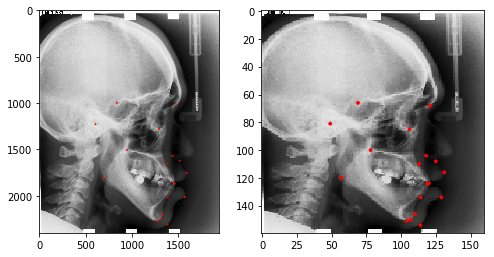

In [8]:
# Take a look at one of the image samples and labels
SAMPLE_PATH = "ceph_test_data/001.bmp"
TXT_PATH = "ceph_test_data/001.txt"
# import sample image
img = io.imread(SAMPLE_PATH, as_grey=True)
# import sample coordinates from csv as tuples
def extract_labels_from_txt(path):
    with open(path, "r") as f:
        # only first 19 are actual coords in dataset label files
        coords_raw = f.readlines()[:18]
        coords_raw = [tuple([int(float(s)) for s in t.split(",")]) for t in coords_raw]
        return coords_raw

coords_raw = extract_labels_from_txt(TXT_PATH)

plt.rcParams["figure.figsize"] = [16,9]
fig = plt.figure()
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 1, 1)
ax1.imshow(img, cmap="gray")
# also plot resized image for later 
orig_y, orig_x = img.shape[:2]
SCALE = 15

# for rescale, use same target for both x&y axis
rescaled_img = transform.resize(img,(orig_y/SCALE,orig_y/SCALE))
ax2.imshow(rescaled_img, cmap="gray")
for c in coords_raw:
    # add marks to original image
    ax1.add_patch(plt.Circle(c, 5, color='r')) 
    # and rescaled marks to resized images
    x,y = c
    x = int(x*(orig_y*1.0/orig_x)/SCALE)
    y = int(y/SCALE)
    ax2.add_patch(plt.Circle((x,y), 1, color='r')) 

plt.show()

In [10]:
# Get list all of the pics in Wang dataset
BASE_PATH = "/Users/franzr/Desktop/main_code/DENT_NEW/data/data_profile/profile/wang_cephalometrics/RawImage"
BASE_LABELS = "/Users/franzr/Desktop/main_code/DENT_NEW/data/data_profile/profile/wang_cephalometrics/AnnotationsByMD/400_senior"

def img_path_walker(base_path, ending):
    # walk through subdirs to get all image paths
    img_paths = []
    for root, _, files in os.walk(base_path):
        for name in files:
            if name.endswith(ending):
                img_paths.append(os.path.abspath(os.path.join(root, name)))
    return img_paths

IMG_PATHS = img_path_walker(BASE_PATH, ".bmp")
# import label coordinates as dict with image names as keys
def label_import(base_labels, ending):
    img_labels = {}
    for label_file in os.listdir(base_labels):
        linked_img = label_file[:-3] + ending
        img_labels[linked_img] = extract_labels_from_txt(base_labels + "/" + label_file)
    return img_labels

IMG_LABELS = label_import(BASE_LABELS, "bmp")

# Image shape is 1935*2400(*3)
# downsize by factor 15 to get 129/160 -> use skimage or torch transform

# helper for rescaling:
def rescale_label_list(label_list):
    # TODO: make parametric, right now takes outside variables
    rescaled_label_list = []
    for tup in label_list:
        x,y = tup
        x = int(x*(2400.0/1935.0)/15.0)
        y = int(y/15.0)
        rsh = (x,y)
        rescaled_label_list.append(rsh)
    #print "rescaled list: ", rescaled_label_list
    return rescaled_label_list

In [11]:
# Network definition
# (((I0−k0+1)/M0)−k1+1)/M1)  
# ((((160−5+1)/2)−3+1)/2)-3+1)/2 = 18 <br>
# CNN Model (3 conv layer)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 24, kernel_size=5),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            # nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.Conv2d(24, 36, kernel_size=3),
            nn.BatchNorm2d(36),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            # nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.Conv2d(36, 48, kernel_size=3),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Sequential(
            nn.Linear(18*18*48, 18*18*48),
            nn.BatchNorm1d(18*18*48),
            nn.ReLU(),
            nn.Linear(18*18*48, 18*48),
            nn.BatchNorm1d(18*48),
            nn.ReLU(),
            nn.Linear(18*48, 18*2))
    
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1) 
        out = self.fc(out)
        return out 

# deeper CNN Model (4 conv layer)
# ((((((160−3+1)/2)-4+1)/2)-3+1)/2-3+1)/2 = 8
# declare from scratch rather than inherit
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 24, kernel_size=3),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            # nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.Conv2d(24, 36, kernel_size=4),
            nn.BatchNorm2d(36),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            # nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.Conv2d(36, 48, kernel_size=3),
            nn.BatchNorm2d(48),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer4 = nn.Sequential(
            nn.Conv2d(48, 72, kernel_size=3),
            nn.BatchNorm2d(72),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Linear(8*8*72, 8*8*72),
            nn.BatchNorm1d(8*8*72),
            nn.ReLU(),
            nn.Linear(8*8*72, 18*2))
    
    def forward(self, x): 
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1) 
        out = self.fc(out)
        return out 


In [12]:
# Hyperparams
num_epochs = 3
batch_size = 10
learning_rate = 0.001

def optimizer(test_net, num_epochs):
    start_time = time.time()
    epoch_data = []
    loss_data = []
    # Loss and Optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(test_net.parameters(), lr=learning_rate)
    # Train the Model
    for epoch in range(num_epochs):
        for i, (data, target) in enumerate(train_loader):
            vd = Variable(data)
            td = Variable(target)

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = test_net(vd)
            loss = criterion(outputs, td)
            loss.backward()
            optimizer.step()

            if (i+1) % 10 == 0:
                # for plotting, append epoch and loss data to timeseries:
                epoch_data.append(epoch+1+(i+1)/10.0) # epochs as 1, 1.5, 2.0 etc
                loss_data.append(loss.data[0])
                # print updates:
                print "Epoch [{}/{}], Iter [{}/{}] Loss: {}".format(epoch+1, num_epochs, i+1, len(train)//batch_size, loss.data[0])
    print("time elapsed: {}".format(time.time()-start_time))
    plt.plot(epoch_data, loss_data)
    plt.ylabel('loss over time')
    plt.xlabel('training epoch')
    plt.show()

In [19]:
BASE_AUG_PATH = "/Users/franzr/Desktop/Dent_PJ_Stuff/dl_progression/aug_img/"
def prep_train_loader(img_path):
    data = []
    target = []
    for i, fi in enumerate(os.listdir(img_path)):
        if fi.endswith(".png"):
            loop_img = io.imread(img_path + fi, as_gray=True)
            lf = fi[:-4] + ".txt"
            loop_labels = extract_labels_from_txt(img_path + lf)
            loop_labels = (np.array(loop_labels) - 80.0)/80.0
            data.append(torch.from_numpy(loop_img).float())
            target.append(torch.from_numpy(loop_labels).float())
    data = torch.from_numpy(np.stack(data))
    data = torch.unsqueeze(data, 1)
    target = torch.stack(target)

    td = TensorDataset(data, target)
    tl = DataLoader(td, batch_size=10, shuffle=False)
    return td, tl

train, train_loader = prep_train_loader(BASE_AUG_PATH)

In [22]:
cnn = CNN()
# deeper_cnn = DeeperCNN()
cnn.load_state_dict(torch.load("first_model_attempt.pth.tar"))

Epoch [1/2], Iter [10/360] Loss: 0.0317500419915
Epoch [1/2], Iter [20/360] Loss: 0.030842544511
Epoch [1/2], Iter [30/360] Loss: 0.0105767156929
Epoch [1/2], Iter [40/360] Loss: 0.00479232007638
Epoch [1/2], Iter [50/360] Loss: 0.00614341162145
Epoch [1/2], Iter [60/360] Loss: 0.00460447836667
Epoch [1/2], Iter [70/360] Loss: 0.00185371388216
Epoch [1/2], Iter [80/360] Loss: 0.00459774909541
Epoch [1/2], Iter [90/360] Loss: 0.00357975950465
Epoch [1/2], Iter [100/360] Loss: 0.00116418604739
Epoch [1/2], Iter [110/360] Loss: 0.00376231805421
Epoch [1/2], Iter [120/360] Loss: 0.00282947695814
Epoch [1/2], Iter [130/360] Loss: 0.000761975825299
Epoch [1/2], Iter [140/360] Loss: 0.00288708275184
Epoch [1/2], Iter [150/360] Loss: 0.00219591008499
Epoch [1/2], Iter [160/360] Loss: 0.000432279950473
Epoch [1/2], Iter [170/360] Loss: 0.00198705680668
Epoch [1/2], Iter [180/360] Loss: 0.0016881392803
Epoch [1/2], Iter [190/360] Loss: 0.00032336669392
Epoch [1/2], Iter [200/360] Loss: 0.0018702

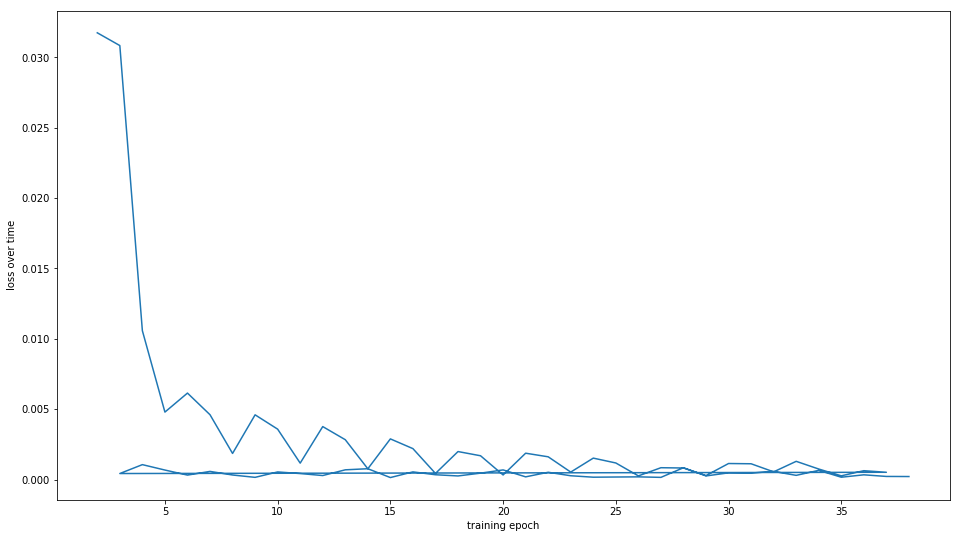

In [90]:
# Hyper Parameters
num_epochs = 2
batch_size = 10
learning_rate = 0.0005
cnn = CNN()
# deeper_cnn = DeeperCNN()
cnn.load_state_dict(torch.load("first_model_attempt.pth.tar"))

optimizer(cnn, num_epochs)

In [91]:
torch.save(cnn.state_dict(), "aug_model_attempt.pth.tar")

In [20]:
TEST_AUG_BASE_PATH = "/Users/franzr/Desktop/Dent_PJ_Stuff/dl_progression/aug_img/TEST_SET/"
test_set, test_set_loader = prep_train_loader(TEST_AUG_BASE_PATH)

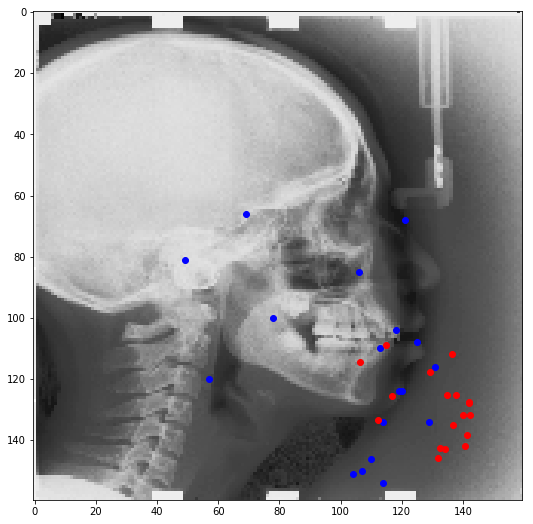

In [29]:
for i, (data, target) in enumerate(test_set_loader):
    # print i
    if i==0:
        some_data =  Variable(data)
        some_target = Variable(target)
test_img = some_data[0].data.numpy().squeeze()

some_target = some_target[0].data.numpy()*80+80
some_target = some_target.tolist()

def group(lst, n):
    # group list into consec tuples
    return zip(*[lst[i::n] for i in range(n)]) 

prediction = cnn(some_data)[1].data.numpy()*80+80
prediction = group(prediction, 2)

plt.imshow(test_img, cmap="gray")
plt.scatter(*zip(*some_target[:]), color="blue")
plt.scatter(*zip(*prediction[:]), color="red")
plt.show()